In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Tạo bộ tăng cường dữ liệu (data augmentation)
train_datagen = ImageDataGenerator(rescale=1.0/255, 
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [4]:
# Áp dụng data augmentation cho tập huấn luyện
train_generator = train_datagen.flow_from_directory(directory="../Project - Copy/Dataset/Gender/Training",
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='categorical')

# Tạo bộ tăng cường dữ liệu cho tập validation (không thay đổi dữ liệu)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Áp dụng data augmentation cho tập validation
validation_generator = validation_datagen.flow_from_directory(directory="../Project - Copy/Dataset/Gender/Validation",
                                                              target_size=(150, 150),
                                                              batch_size=32,
                                                              class_mode='categorical')

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [5]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(1.0112506991352235), 1: np.float64(0.9889968863081713)}


In [6]:
# Khởi tạo mô hình CNN
model = Sequential()

# Các lớp Convolutional
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3))) # out = (kichthuocanh - (kernel - 1)) / s
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flatten
model.add(Flatten())

# Fully-connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(2, activation='softmax'))

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [8]:
# Compile mô hình
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Sử dụng EarlyStopping để dừng quá trình huấn luyện sớm nếu không có cải tiến đáng kể
early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

In [9]:
# Huấn luyện mô hình
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // train_generator.batch_size,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[early_stopping])

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 562s 382ms/step - accuracy: 0.6491 - loss: 0.6038 - val_accuracy: 0.9193 - val_loss: 0.2137
Epoch 2/20
   1/1469 ━━━━━━━━━━━━━━━━━━━━ 7:16 298ms/step - accuracy: 0.9062 - loss: 0.2081

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1469/1469 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - accuracy: 0.9062 - loss: 0.2081 - val_accuracy: 0.9352 - val_loss: 0.1725
Epoch 3/20
 746/1469 ━━━━━━━━━━━━━━━━━━━━ 4:42 391ms/step - accuracy: 0.8893 - loss: 0.2780

In [9]:
# Đánh giá độ chính xác của mô hình
score = model.evaluate(train_generator,verbose=0)
print('Sai số kiểm tra là: ',score[0])
print('Độ chính xác kiểm tra là: ',score[1])

ValueError: You must call `compile()` before using the model.

In [10]:
import matplotlib.pyplot as plt
# Draw plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','Validation'])
plt.show()

NameError: name 'history' is not defined

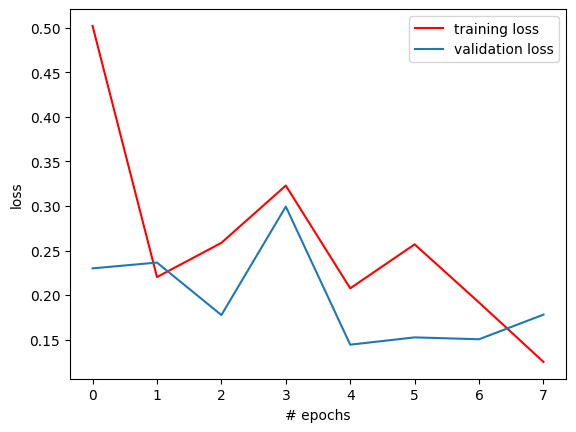

In [12]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [11]:
from tensorflow.keras.models import load_model
model.save('Gender2.h5')

{'female': 0, 'male': 1}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


array(['Male'], dtype='<U6')

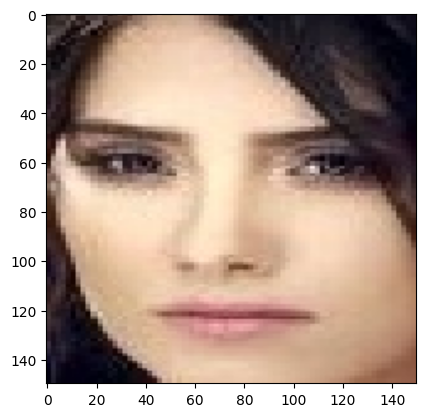

In [20]:
model_CNN = load_model('Gender2.h5')
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
filename = "../Project - Copy/Dataset/Gender/Validation/female/112944.jpg.jpg"

predict = np.array(['Female', 'Male'])
print(train_generator.class_indices)  # Kiểm tra thứ tự nhãn để chắc chắn

# predict = np.array(['Female', 'Male'])  # Nếu kết quả in ra là {'female': 0, 'male': 1}

img = load_img(filename,target_size=(150,150))
plt.imshow(img)

img = img_to_array(img)
img = img.reshape(1,150,150,3)
img = img.astype('float32')
img = img/255


result = np.argmax(model_CNN.predict(img),axis=-1)
predict[result]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


array(['Female'], dtype='<U6')

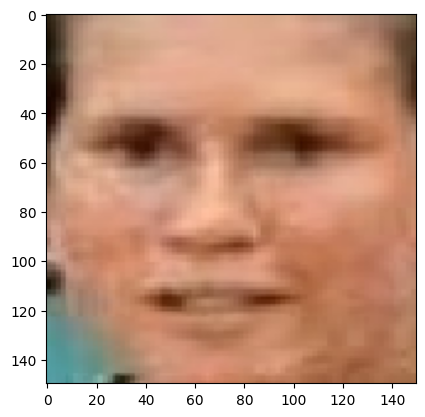

In [12]:
model_CNN = load_model('Gender2.h5')
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
filename = "../Project - Copy/Dataset/Gender/Validation/male/063429.jpg.jpg"

predict = ['Male','Female']
predict = np.array(predict)
img = load_img(filename,target_size=(150,150))
plt.imshow(img)

img = img_to_array(img)
img = img.reshape(1,150,150,3)
img = img.astype('float32')
img = img/255


result = np.argmax(model_CNN.predict(img),axis=-1)
predict[result]

In [17]:
import numpy as np

# In ra số lượng ảnh của mỗi class
print("Số lượng ảnh theo từng lớp trong train_generator:")
for class_name, count in zip(train_generator.class_indices.keys(), np.bincount(train_generator.classes)):
    print(f"{class_name}: {count}")


Số lượng ảnh theo từng lớp trong train_generator:
female: 23243
male: 23766


In [18]:
import os

male_folder = "../Project - Copy/Dataset/Gender/Training/male"
female_folder = "../Project - Copy/Dataset/Gender/Training/female"

print("Số ảnh trong Training/male:", len(os.listdir(male_folder)))
print("Số ảnh trong Training/female:", len(os.listdir(female_folder)))


Số ảnh trong Training/male: 23766
Số ảnh trong Training/female: 23243
